## 导入必要的包

In [25]:
import os
import paddle
import numpy as np
from visualdl import LogWriter
from PIL import Image
import paddle.nn.functional as F
from paddle.io import Dataset
from paddle.vision.transforms import Normalize
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## 数据集制作

将数据集类别分开，其中`Cat:0, Dog:1`

In [66]:
datadir = 'cats_vs_dogs/train'
image_path = ['cats_vs_dogs/train/' + filename for filename in os.listdir(datadir)]
labels = []
images = []
i = 0
for filename in image_path:
    i += 1
    if i % 500 == 0:
        print('INFO:%4d images have been dealt' % i)
    images.append(Image.open(filename))
    if filename.split('/')[-1].split('.')[0] == 'cat':
        labels.append(0)
    else:
        labels.append(1)

INFO: 500 images have been dealt
INFO:1000 images have been dealt
INFO:1500 images have been dealt
INFO:2000 images have been dealt
INFO:2500 images have been dealt
INFO:3000 images have been dealt
INFO:3500 images have been dealt
INFO:4000 images have been dealt
INFO:4500 images have been dealt
INFO:5000 images have been dealt
INFO:5500 images have been dealt


将图片路径及其对应的标签以相同的方式打乱

In [3]:
randnum = random.randint(0,100)
random.seed(randnum)
random.shuffle(images)
random.seed(randnum)
random.shuffle(labels)

图像归一化操作

In [4]:
normalize = Normalize(mean=[127.5, 127.5, 127.5],
                      std=[127.5, 127.5, 127.5],
                      data_format='HWC')

## 数据集装载

In [5]:
class CatsDogsDataset(Dataset):
    def __init__(self, mode='train'):
        super(CatsDogsDataset, self).__init__()
        self.data = [[normalize(images[i].resize((224, 224))).transpose(2, 0, 1), np.array(labels[i]).astype('int64')] for i in range(len(labels))]
    def __getitem__(self, index):
        data = self.data[index][0]
        label = self.data[index][1]

        return data, label

    def __len__(self):
        return len(self.data)

In [6]:
train_data = CatsDogsDataset(mode='train')

In [7]:
train_loader = paddle.io.DataLoader(train_data, batch_size=64, shuffle=True)

## 构建VGG网络

下面的一行代码也可以用这四行代替
```python
from paddle.utils.download import get_weights_path_from_url

vgg16_pretrained_weight_url = 'https://paddle-hapi.bj.bcebos.com/models/vgg16.pdparams'
local_weight_path = get_weights_path_from_url(vgg16_pretrained_weight_url)
layer_state_dict = paddle.load(local_weight_path)
vgg16.set_state_dict(layer_state_dict)
```

In [8]:
vgg16 = paddle.vision.models.vgg16(pretrained=True)

只训练最后一层全连接的权重，因为权重包含了偏置项`bias`因此，使用`len(vgg16.parameters())`的结果是32，因为每一层网络都包含相应的偏置项，因此我们要用`len(vgg16.parameters())-2`

In [9]:
for i in range(len(vgg16.parameters())-2):
    vgg16.parameters()[i].trainable = False

沿用VGG网络的卷积池化层，重写全连接层，其中`vgg16.sublayers()[0]`代表全部的卷积池化层，`vgg16.sublayers()[32]`代表全局池化层

In [10]:
class CatsDogsVGG16(paddle.nn.Layer):
    def __init__(self):
        super(CatsDogsVGG16, self).__init__()
        self.top = paddle.nn.Sequential(vgg16.sublayers()[0],
                                 vgg16.sublayers()[32])
        self.flatten = paddle.nn.Flatten()
        self.fc1 = paddle.nn.Linear(25088, 128)
        self.fc2 = paddle.nn.Linear(128, 32)
        self.fc3 = paddle.nn.Linear(32, 2)
                                 
        

    def forward(self, inputs):
        top = self.top(inputs)
        fc1 = self.fc1(self.flatten(top))
        fc1 = F.relu(fc1)
        fc1 = F.dropout(fc1)
        fc2 = self.fc2(fc1)
        fc2 = F.relu(fc2)
        fc2 = F.dropout(fc2)
        pred = self.fc3(fc2)
        return pred

In [11]:
network = CatsDogsVGG16()

查看模型摘要，在网络中我们的激活函数以及`dropout`采用的`paddle.nn.functional`中的操作，因此在摘要中全连接部分并未显示

In [12]:
paddle.summary(network, (1, 3, 224, 224))

-------------------------------------------------------------------------------
   Layer (type)         Input Shape          Output Shape         Param #    
     Conv2D-1        [[1, 3, 224, 224]]   [1, 64, 224, 224]        1,792     
      ReLU-1        [[1, 64, 224, 224]]   [1, 64, 224, 224]          0       
     Conv2D-2       [[1, 64, 224, 224]]   [1, 64, 224, 224]       36,928     
      ReLU-2        [[1, 64, 224, 224]]   [1, 64, 224, 224]          0       
    MaxPool2D-1     [[1, 64, 224, 224]]   [1, 64, 112, 112]          0       
     Conv2D-3       [[1, 64, 112, 112]]   [1, 128, 112, 112]      73,856     
      ReLU-3        [[1, 128, 112, 112]]  [1, 128, 112, 112]         0       
     Conv2D-4       [[1, 128, 112, 112]]  [1, 128, 112, 112]      147,584    
      ReLU-4        [[1, 128, 112, 112]]  [1, 128, 112, 112]         0       
    MaxPool2D-2     [[1, 128, 112, 112]]   [1, 128, 56, 56]          0       
     Conv2D-5        [[1, 128, 56, 56]]    [1, 256, 56, 56]   

{'total_params': 17930274, 'trainable_params': 3215586}

由于硬件资源有限，这里我只训练一个EPOCH，大家可以在AIStudio上使用免费的算力进行训练，可以达到更优的结果

In [14]:
print('start training ... ')

EPOCH_NUM = 1
BATCH_SIZE = 64
train_num = 0
train_loss_list = []
optimizer = paddle.optimizer.SGD(learning_rate=0.001, parameters=network.parameters())

network.train()

with LogWriter(logdir="./log") as writer:
    for epoch_id in range(EPOCH_NUM):
        i = 0
        for data, label in train_loader:
            i += 1
            y_pred = network(data)
            loss = F.cross_entropy(y_pred, label=label)
            train_loss = loss.numpy()[0]
            train_acc = sum((paddle.argmax(y_pred, axis=1) == label).numpy()) / len(label)
            loss.backward()
            optimizer.step()
            optimizer.clear_grad()
            print("INFO:%d EPOCH, %d BATCH, Loss:%0.5f, Acc:%0.5f"%(epoch_id, i, train_loss, train_acc))
            writer.add_scalar(tag="train loss", step=i, value=train_loss)
            writer.add_scalar(tag="train acc", step=i, value=train_acc)


start training ... 
INFO:0 EPOCH, 1 BATCH, Loss:10.93494, Acc:0.46875
INFO:0 EPOCH, 2 BATCH, Loss:4.77267, Acc:0.62500
INFO:0 EPOCH, 3 BATCH, Loss:3.31533, Acc:0.68750
INFO:0 EPOCH, 4 BATCH, Loss:3.72801, Acc:0.62500
INFO:0 EPOCH, 5 BATCH, Loss:3.45116, Acc:0.68750
INFO:0 EPOCH, 6 BATCH, Loss:3.02374, Acc:0.70312
INFO:0 EPOCH, 7 BATCH, Loss:2.53811, Acc:0.73438
INFO:0 EPOCH, 8 BATCH, Loss:2.67587, Acc:0.79688
INFO:0 EPOCH, 9 BATCH, Loss:1.30491, Acc:0.82812
INFO:0 EPOCH, 10 BATCH, Loss:2.92140, Acc:0.70312
INFO:0 EPOCH, 11 BATCH, Loss:2.78632, Acc:0.75000
INFO:0 EPOCH, 12 BATCH, Loss:0.66669, Acc:0.89062
INFO:0 EPOCH, 13 BATCH, Loss:1.13641, Acc:0.84375
INFO:0 EPOCH, 14 BATCH, Loss:0.87696, Acc:0.87500
INFO:0 EPOCH, 15 BATCH, Loss:0.62798, Acc:0.89062
INFO:0 EPOCH, 16 BATCH, Loss:1.46720, Acc:0.84375
INFO:0 EPOCH, 17 BATCH, Loss:1.49004, Acc:0.78125
INFO:0 EPOCH, 18 BATCH, Loss:1.64416, Acc:0.81250
INFO:0 EPOCH, 19 BATCH, Loss:1.03853, Acc:0.78125
INFO:0 EPOCH, 20 BATCH, Loss:1.72216, 

## 模型的保存

模型保存

In [16]:
paddle.save(network.state_dict(), "cats_vs_dogs.pdparams")

模型加载

In [17]:
cats_vs_dogs_dict = paddle.load("cats_vs_dogs.pdparams")
network.set_state_dict(cats_vs_dogs_dict)

## 模型预测及其可视化

模型预测

In [32]:
predict_image_path = ['cats_vs_dogs/test/' + filename for filename in os.listdir('cats_vs_dogs/test/')]

In [62]:
def plot_num_images(num):
    if num < 1:
        print('INFO:The number of input pictures must be greater than zero!')
    else:
        choose_list = []
        for i in range(num):
            choose_n = np.random.randint(len(predict_image_path))
            choose_list.append(choose_n)
        fig = plt.gcf()
        fig.set_size_inches(18, 10)
        for i in range(num):
            ax_img = plt.subplot(3, 3, i + 1)
            plt_img = Image.open(predict_image_path[choose_list[i]])
            ax_img.imshow(plt_img, cmap='binary')
            if paddle.argmax(network(paddle.to_tensor([normalize(plt_img).transpose(2, 0, 1)]))).numpy() == 0:
                class_name = 'cat'
            else:
                class_name = 'dog'
            ax_img.set_title(class_name, fontsize=10)
        plt.show()


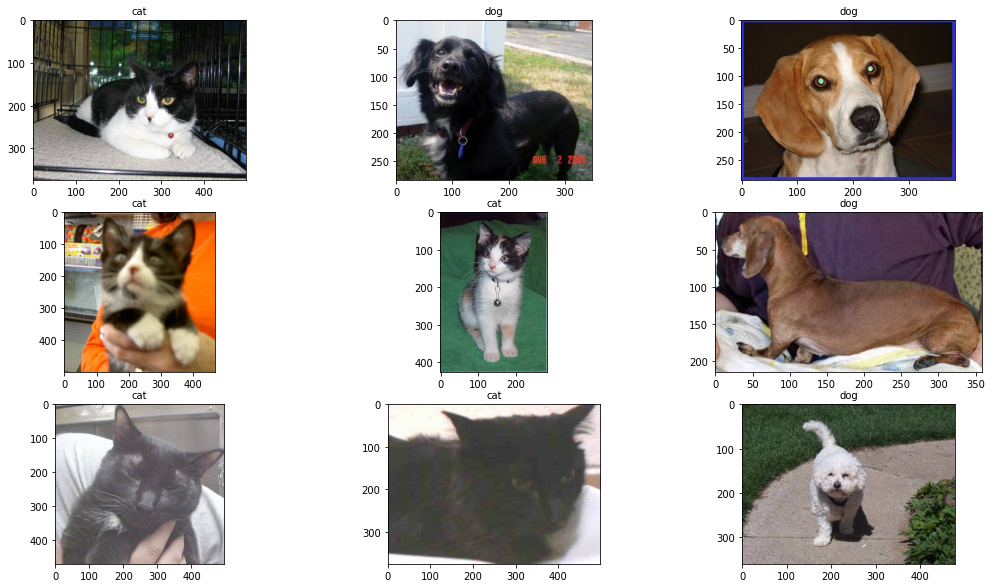

In [64]:
plot_num_images(9)

## VisualDL可视化

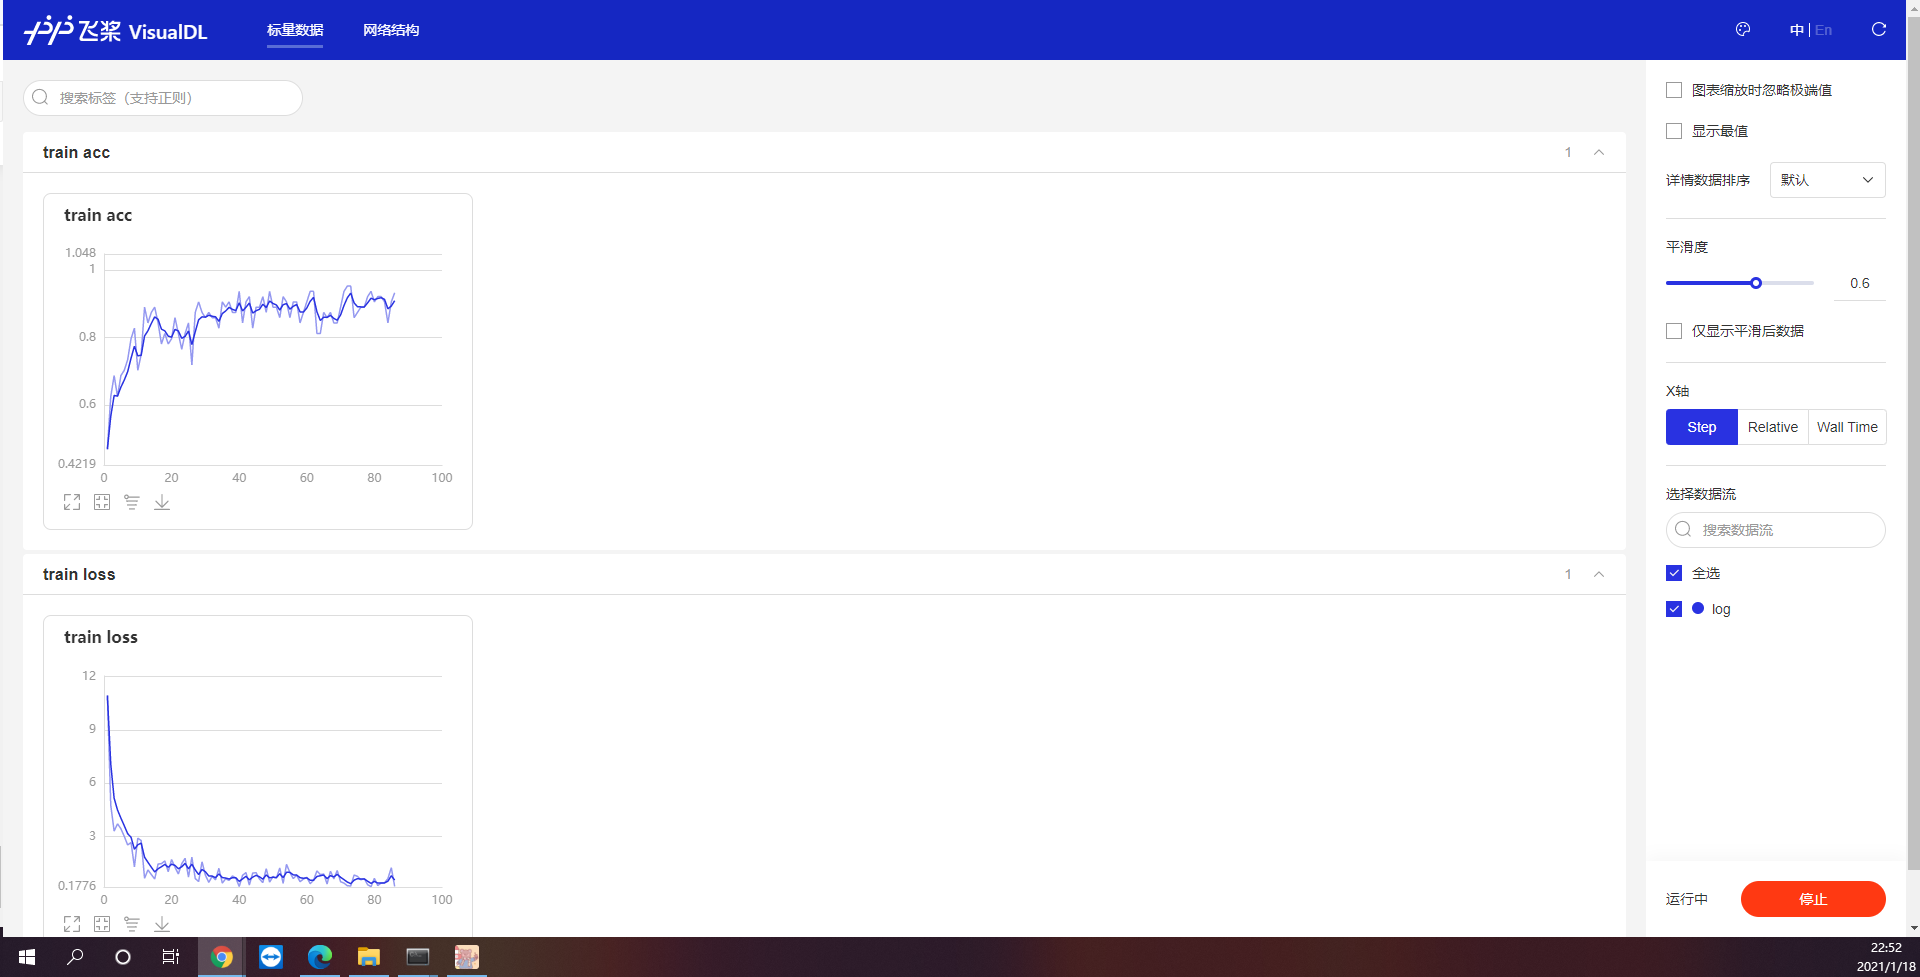